# Functions and Class from github

## Multilabel_train_test_split functions

 We will use the multilabel_train_test_split function. You may find the source of the function [here](https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/data/multilabel.py)

In [1]:
from warnings import warn

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

## SparseInteractions

You may find the source code [here](https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/features/SparseInteractions.py)


In [2]:
from itertools import combinations

from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin


class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

# Import library and data

On the top of numpy and pandas, we will use matplotlib, seaborn for plotting graph. More importantly, we will use sklearn for data preprocessing and machine learning model.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier

We use pd.read_csv to read the files.

In [4]:
data = pd.read_csv("https://s3.amazonaws.com:443/drivendata/data/4/public/81e8f2de-9915-4934-b9ae-9705685c9d50.csv", index_col=0)

# Have a closer look to the data

In [5]:
data.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

In [7]:
data.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


## Numerical columns

In [8]:
num_cols = ["FTE", "Total"]

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.26017e+05, 2.00000e+01, 1.60000e+01, 7.00000e+00, 4.00000e+00,
        2.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([-0.08755064,  4.60120443,  9.28995949, 13.97871455, 18.66746962,
        23.35622468, 28.04497975, 32.73373481, 37.42248987, 42.11124494,
        46.8       ]),
 <a list of 10 Patch objects>)

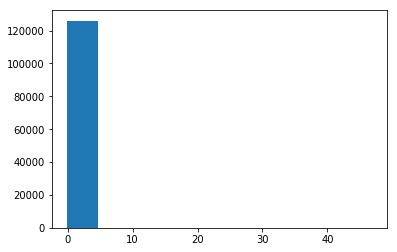

In [9]:
plt.hist(data["FTE"])

(array([1.00000e+00, 1.00000e+00, 4.00000e+00, 6.30000e+01, 3.95637e+05,
        1.30000e+01, 2.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-8.74663072e+07, -6.57496765e+07, -4.40330459e+07, -2.23164152e+07,
        -5.99784602e+05,  2.11168460e+07,  4.28334767e+07,  6.45501073e+07,
         8.62667379e+07,  1.07983369e+08,  1.29699999e+08]),
 <a list of 10 Patch objects>)

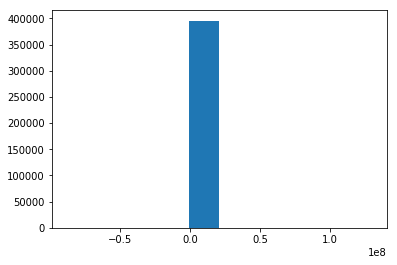

In [10]:
plt.hist(data["Total"])

## Label Columns

In [11]:
label_cols = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type',
              'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
data[label_cols] = data[label_cols].apply(lambda x:x.astype('category'),axis=0)
data.dtypes

Function                  category
Use                       category
Sharing                   category
Reporting                 category
Student_Type              category
Position_Type             category
Object_Type               category
Pre_K                     category
Operating_Status          category
Object_Description          object
Text_2                      object
SubFund_Description         object
Job_Title_Description       object
Text_3                      object
Text_4                      object
Sub_Object_Description      object
Location_Description        object
FTE                        float64
Function_Description        object
Facility_or_Department      object
Position_Extra              object
Total                      float64
Program_Description         object
Fund_Description            object
Text_1                      object
dtype: object

In [12]:
label_dummies = pd.get_dummies(data[label_cols],)

## Text Features

Now, only the categorical features have data type equal to 'object'. We can easily retrive these columns. 

In [13]:
text_cols = data.dtypes[data.dtypes=='object'].index.tolist()
text_cols

['Object_Description',
 'Text_2',
 'SubFund_Description',
 'Job_Title_Description',
 'Text_3',
 'Text_4',
 'Sub_Object_Description',
 'Location_Description',
 'Function_Description',
 'Facility_or_Department',
 'Position_Extra',
 'Program_Description',
 'Fund_Description',
 'Text_1']

# Subset

## Down-Sampling

In [14]:
SAMPLE_SIZE=70000
samples = multilabel_sample_dataframe(data, label_dummies, size=SAMPLE_SIZE, min_count=25, seed=42)
subset_label_dummies = pd.get_dummies(samples[label_cols], prefix="__")

In [15]:
del data

In [16]:
text_nunique = [samples[col].nunique() for col in text_cols]
max_text_nunique = max(text_nunique)
print(f"Max: {max_text_nunique}")
print(f"Sum: {sum(text_nunique)}")

Max: 2072
Sum: 6098


## Train Test Split

In [17]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(samples[num_cols+text_cols], subset_label_dummies, size=0.1,seed=42)

# Logistic Regression

## Pipeline

In [18]:
def combine_text_columns(df, selected_cols=text_cols):
    df_text = df[selected_cols]
    df_text.fillna("", inplace=True)
    return df_text.apply(lambda x:" ".join(x[selected_cols]), axis=1)

In [19]:
get_numeric_cols = FunctionTransformer(lambda x:x[num_cols], validate=False)
get_text_cols = FunctionTransformer(combine_text_columns, validate=False)

fill_na = FunctionTransformer(lambda x:x.fillna(-1000), validate=False)

In [20]:
token_pattern = r'[a-zA-z0-9]+'

In [21]:
logreg_pl = Pipeline([('union', FeatureUnion([
                        ('numeric', Pipeline([
                                              ('selector', get_numeric_cols),
                                              ('na_filler', fill_na)
                                              ])),
                        ('text', Pipeline([
                                          ('selector', get_text_cols),
                                          ('vectorizer', CountVectorizer(token_pattern=token_pattern,
                                                                          ngram_range=(1,1),
                                                                          max_df=0.8, 
                                                                          min_df=20
                                                                          ))
                                          ]))
                                      ])),
               ('int', SparseInteractions(degree=2)),
               ('scale', MaxAbsScaler()), #since MaxMinScaler does not support sparse input, we use MaxAbsScaler
               ('clf', OneVsRestClassifier(LogisticRegression()))
              ])

In [22]:
logreg_pl.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numeric',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x7faf06f16ea0>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                                                

## Evaluation of the model

The loss function is given in the DrivenData page.

In [23]:
logloss = lambda y_true, y_predicted_proba: np.sum(-np.mean(y_true*np.log(y_predicted_proba),axis=0))/9

In [24]:
y_train_logreg = logreg_pl.predict_proba(X_train)
y_test_logreg = logreg_pl.predict_proba(X_test)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [25]:
logloss(y_train,y_train_logreg)

0.04285105977462825

In [26]:
logloss(y_test,y_test_logreg)

0.1051659876717894

# Submission

In [27]:
holdout = pd.read_csv("https://s3.amazonaws.com:443/drivendata/data/4/public/d0fcd6d3-5bc5-4869-b4e6-d12ecb2ff517.csv",index_col=0)
submission_format = pd.read_csv("https://s3.amazonaws.com:443/drivendata/data/4/public/SubmissionFormat.csv",index_col=0)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
y_holdout_logreg = logreg_pl.predict_proba(holdout)

We can check whether the order of the label_dummies features matches the one given from the submission format.

In [29]:
label_dummies_cols = pd.get_dummies(samples[label_cols],prefix_sep="__").columns

In [30]:
sum([s==t for s,t in zip(submission_format.columns,label_dummies.columns)])==104

False

In [31]:
sum(submission_format.index==holdout.index)==len(submission_format.index)

True

In [32]:
submission = pd.DataFrame(data=y_holdout_logreg,columns=submission_format.columns,index=submission_format.index)

In [33]:
submission.to_csv("submission.csv",index=True)

In [34]:
pd.read_csv("submission.csv",index_col=0).head()

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
180042,0.000491,0.000723,0.000041,0.000255,0.000258,0.000097,0.000571,0.000264,0.001363,0.000027,...,0.002352,0.717005,0.000446,0.003431,0.783250,0.002670,0.077947,0.009620,0.001428,0.000395
28872,0.000224,0.000730,0.000081,0.000636,0.000317,0.000069,0.084252,0.001275,0.001600,0.000042,...,0.001476,0.911037,0.008741,0.001466,0.007119,0.065368,0.026587,0.005361,0.061268,0.000142
186915,0.008147,0.001347,0.000106,0.001259,0.000249,0.000122,0.001431,0.000248,0.000972,0.000027,...,0.022545,0.274203,0.001199,0.007163,0.658835,0.013222,0.020297,0.002900,0.021366,0.000065
412396,0.006901,0.001264,0.000104,0.001207,0.000242,0.000120,0.001338,0.000238,0.000881,0.000027,...,0.020175,0.274728,0.001126,0.006204,0.728611,0.011855,0.016473,0.002471,0.018847,0.000065
427740,0.001409,0.003383,0.000182,0.001245,0.000643,0.000142,0.001774,0.000176,0.001529,0.000033,...,0.005693,0.958551,0.001470,0.020561,0.005971,0.602653,0.007455,0.016814,0.013035,0.000073
